## **1. Carga de paquetes**

In [22]:
#!pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.utils import acf,pacf
from pmdarima.arima import ARIMA
import pandas as pd
import numpy as np 
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos 
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

## **2. Carga de datos**

In [53]:
data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


## **4. Revisión Estructura de la Serie**

In [24]:
acf(data['Ocupados'],40)

array([1.        , 0.97923589, 0.96362413, 0.95086793, 0.94043553,
       0.92969259, 0.91713405, 0.90706034, 0.89397301, 0.88399232,
       0.87530735, 0.87098372, 0.86597826, 0.84721366, 0.83017347,
       0.81678605, 0.80762818, 0.79697425, 0.78407137, 0.7731639 ,
       0.7600653 , 0.74812334, 0.74003564, 0.73382138, 0.72802239,
       0.71034489, 0.69224206, 0.67747509, 0.66521217, 0.65359545,
       0.63806496, 0.62512757, 0.61192566, 0.60000466, 0.59141481,
       0.58454874, 0.57785757, 0.55818054, 0.54021702, 0.52497098,
       0.51302032])

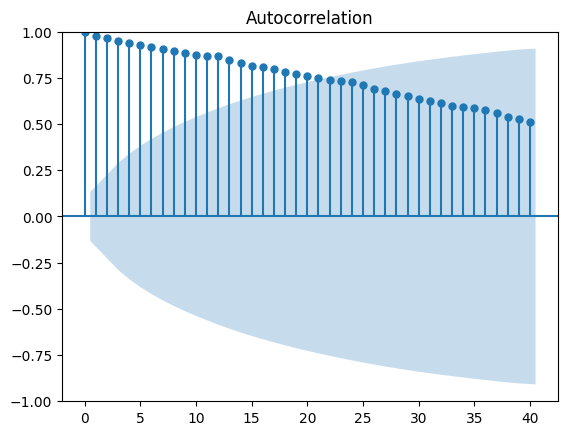

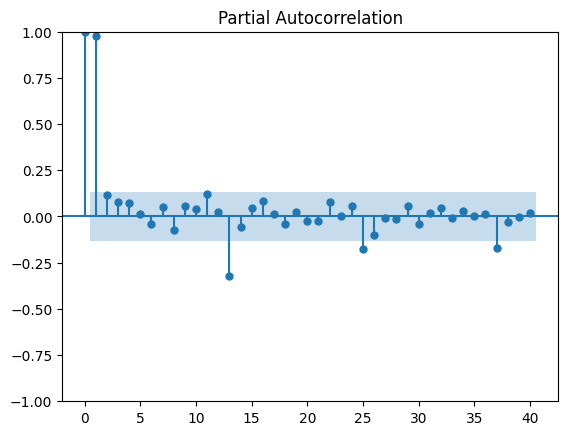

In [25]:
plot_acf(data['Ocupados'],lags=40);
plot_pacf(data['Ocupados'],lags=40);

###  
- Dado que el ACF muestra una disminución lenta, prodía necesitarse hacer una diferenciación para hacer los datos estacionarios. Por tanto se puede evaluar con un Modelo ARIMA.
- Analizando el PACF se puede observar que hay significativas correlaciones parciales en los primeros lags, ya que están muy por encima de la zona de confianza y luego la correlación desaparece rápidamente, esto podría sigerir que un modelo autorregresivo (AR) con un orden 2 podría capturar adecuadamente la estructura de los datos.


## **4. Protocolo de Evaluación**

In [64]:
#data.set_index('mes', inplace=True)

target_column = 'Ocupados'

train_size = len(data) - 6  # Dejamos los últimos 6 meses para predicción
X_train = data[target_column].iloc[:train_size] 
X_test = data[target_column].iloc[train_size:]   

## **5. Aplicar AUTOARIMA Para encontrar los mejores parámetros**

In [65]:
model = auto_arima(X_train, 
                   max_p=10, 
                   max_q=10, 
                   information_criterion='aic', 
                   trace=True, 
                   error_action='ignore',  # Ignorar si no se puede ajustar un modelo
                   suppress_warnings=True, # Suprimir advertencias
                   stepwise=True,
                   seasonal=False) 

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2839.801, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2830.184, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2821.028, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2839.858, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2800.549, Time=1.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2801.991, Time=1.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2802.110, Time=1.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2803.646, Time=1.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2824.594, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2818.369, Time=0.44 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 8.603 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  214
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1396.275
Date:                Mon, 19 Aug 2024   AIC                           2800.549
Time:                        10:24:33   BIC                           2813.994
Sample:                    01-01-2001   HQIC                          2805.983
                         - 10-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.3399      2.394      4.320      0.000       5.648      15.031
ar.L1          0.4455      0.096      4.657      0.000       0.258       0.633
ma.L1         -0.8728      0.048    -18.169      0.000      -0.967      -0.779
sigma2      2.871e+04   2475.362     11.598      0.000    2.39e+04    3.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                48.07
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.93
Prob(H) (two-sided):                  0.30   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **6. Predicción**

            Predicciones  Valores Reales
mes                                     
2018-11-01  10918.120066       10783.299
2018-12-01  10947.966710       10835.398
2019-01-01  10971.604533       10314.438
2019-02-01  10992.476064       10557.917
2019-03-01  11012.115095       10760.776
2019-04-01  11031.204995       10632.028


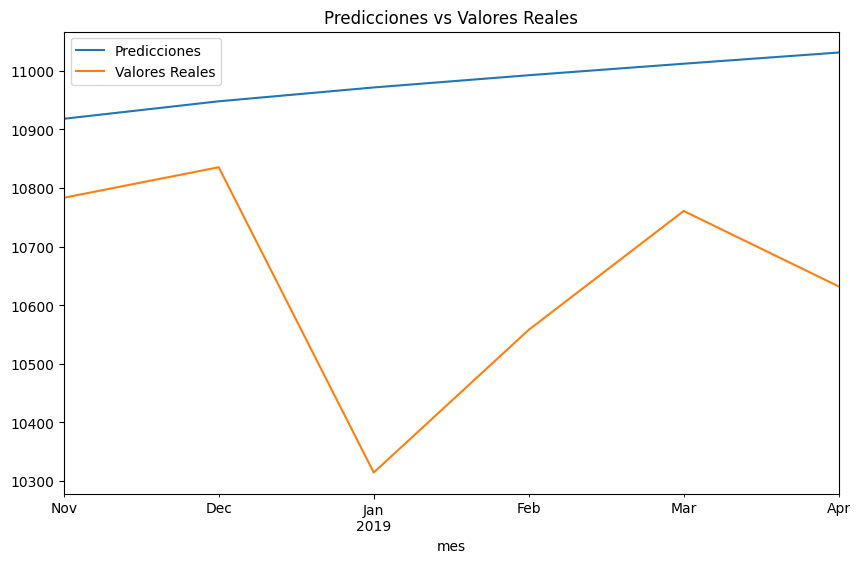

In [66]:
# Realizar predicciones usando el modelo ajustado
n_periods = len(X_test)  # El número de períodos que deseas predecir (6 meses, por ejemplo)
forecast = model.predict(n_periods=n_periods)

# Crear un DataFrame para comparar predicciones con los valores reales
predicted_vs_actual = pd.DataFrame({
    'Predicciones': forecast,
    'Valores Reales': X_test.values
}, index=X_test.index)

# Imprimir la comparación
print(predicted_vs_actual)

# Opcional: Visualizar la comparación
import matplotlib.pyplot as plt

predicted_vs_actual.plot(figsize=(10, 6))
plt.title("Predicciones vs Valores Reales")
plt.show()

### EVALUACIÓN DEL MODELO

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calcular el MAE y el RMSE
mae = mean_absolute_error(X_test, forecast)
rmse = np.sqrt(mean_squared_error(X_test, forecast))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 331.6052435650254
RMSE: 381.67863425887265


In [72]:
# Ajustar el modelo y obtener predicciones con intervalo de confianza
h = 6  # Horizonte de predicción de 6 meses
y_forec, conf_int = model.predict(h, return_conf_int=True, alpha=0.05)

# Crear un DataFrame para almacenar las predicciones y los intervalos de confianza
preds = pd.DataFrame(np.column_stack([y_forec, conf_int[:, 0], conf_int[:, 1]]), 
                     columns=['Point_forecast', 'lower_95', 'upper_95'])

In [70]:
fechas_pronostico = X_test.index
df_pronostico = pd.DataFrame(data=y_forec, index=fechas_pronostico, columns=['Pronóstico'])
df_pronostico['Intervalo Inferior'] = conf_int[:, 0]
df_pronostico['Intervalo Superior'] = conf_int[:, 1]

# Evaluar el Modelo
rmse = np.sqrt(mean_squared_error(X_test, y_forec))
print(f'RMSE en el conjunto de prueba: {rmse}')

RMSE en el conjunto de prueba: 381.67863425887265


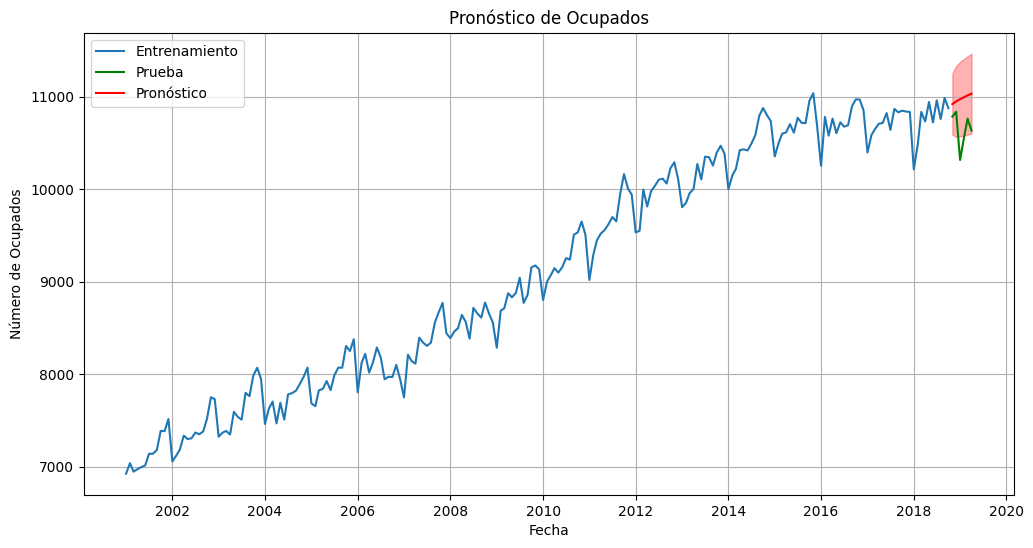

In [71]:
# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(X_train, label='Entrenamiento')
plt.plot(X_test, label='Prueba', color='green')
plt.plot(df_pronostico.index, df_pronostico['Pronóstico'], color='red', label='Pronóstico')
plt.fill_between(df_pronostico.index, df_pronostico['Intervalo Inferior'], df_pronostico['Intervalo Superior'], color='red', alpha=0.3)
plt.title('Pronóstico de Ocupados')
plt.xlabel('Fecha')
plt.ylabel('Número de Ocupados')
plt.legend()
plt.grid(True)
plt.show()

## **7. Aplicación del Modelo con el Dataset Completo**

In [73]:
model = ARIMA(order=(1,1,1))
results = model.fit( data["Ocupados"])
results.summary()

c:\Users\aleja\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  220
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1439.368
Date:                Mon, 19 Aug 2024   AIC                           2886.736
Time:                        10:42:22   BIC                           2900.292
Sample:                    01-01-2001   HQIC                          2892.211
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.8034      2.519      3.892      0.000       4.866      14.740
ar.L1          0.4417      0.103      4.285      0.000       0.240       0.644
ma.L1         -0.8600      0.054    -15.921      0.000      -0.966      -0.754
sigma2      2.973e+04   2523.649     11.779      0.000    2.48e+04    3.47e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                55.64
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.98
Prob(H) (two-sided):                  0.28   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **8. Pronóstico del Modelo**

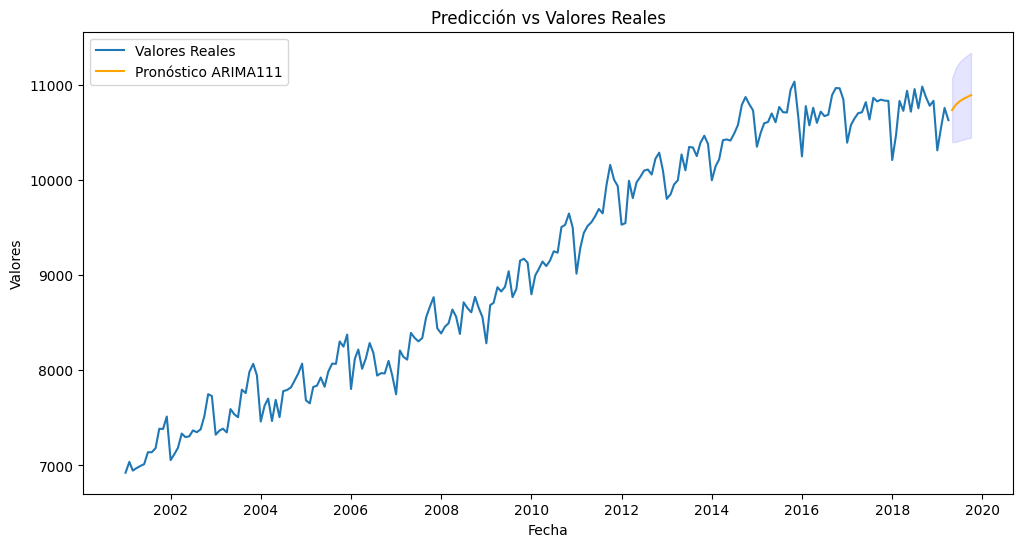

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que el modelo ARIMA ya ha sido ajustado
h = 6 # Horizonte de predicción de 6 períodos

# Realizar las predicciones usando el modelo ARIMA ajustado
y_forec, conf_int = model.predict(h, return_conf_int=True, alpha=0.05)

# Crear un DataFrame para las predicciones y los intervalos de confianza
preds = pd.DataFrame(np.column_stack([y_forec, conf_int[:, 0], conf_int[:, 1]]), 
                     columns=['Point_forecast', 'lower_95', 'upper_95'])

# Generar el índice temporal para las predicciones (suponiendo datos mensuales)
x_for = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=h, freq='MS')

# Graficar los valores reales y las predicciones
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar los datos reales
ax.plot(data.index, data["Ocupados"], label="Valores Reales")

# Graficar las predicciones puntuales
ax.plot(x_for, preds['Point_forecast'], label="Pronóstico ARIMA111", color='orange')

# Agregar la banda de confianza
ax.fill_between(x_for, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)

# Ajustar etiquetas y leyenda
ax.set_title("Predicción vs Valores Reales")
ax.set_xlabel("Fecha")
ax.set_ylabel("Valores")
ax.legend()

# Mostrar la gráfica
plt.show()

## **9. Residuales**

In [87]:
residuals = model.resid().iloc[1:]

In [88]:
residuals

mes
2001-02-01    160.445053
2001-03-01    -38.368400
2001-04-01     28.648670
2001-05-01     22.307209
2001-06-01     18.519978
                 ...    
2018-12-01    -26.574710
2019-01-01   -576.628088
2019-02-01    -32.158889
2019-03-01     57.864946
2019-04-01   -178.378912
Length: 219, dtype: float64

## Verificar Supuestos

### Normalidad

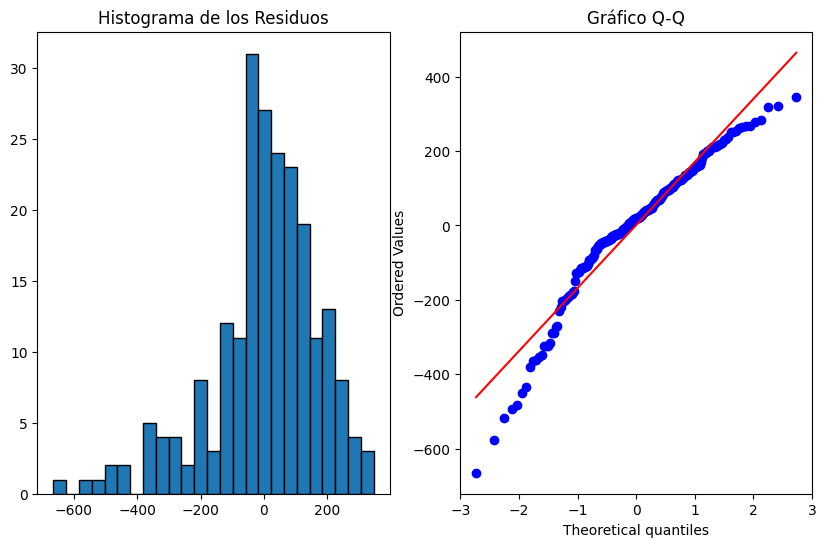

In [90]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Histograma de los residuos
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.hist(residuals, bins=25, edgecolor='k')
plt.title("Histograma de los Residuos")

# Gráfico Q-Q
plt.subplot(122)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Gráfico Q-Q")
plt.show()

In [91]:
from scipy.stats import shapiro

stat, p = shapiro(residuals)
print(f'Statistic: {stat}, p-value: {p}')

if p > 0.05:
    print("No se rechaza la hipótesis nula: los residuos son normales")
else:
    print("Se rechaza la hipótesis nula: los residuos no son normales")

Statistic: 0.9434764053827344, p-value: 1.6014196159608286e-07
Se rechaza la hipótesis nula: los residuos no son normales


### Autocorrelación

In [95]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

     lb_stat  lb_pvalue
10  9.216943   0.511646


#### No hay evidencia suficiente para rechazar la hipótesis nula. Esto significa que no se detecta autocorrelación significativa en los residuos. Los residuos parecen ser independientes, lo cual es una indicación de que el modelo está capturando la estructura de los datos correctamente.

### Homoscedasticidad

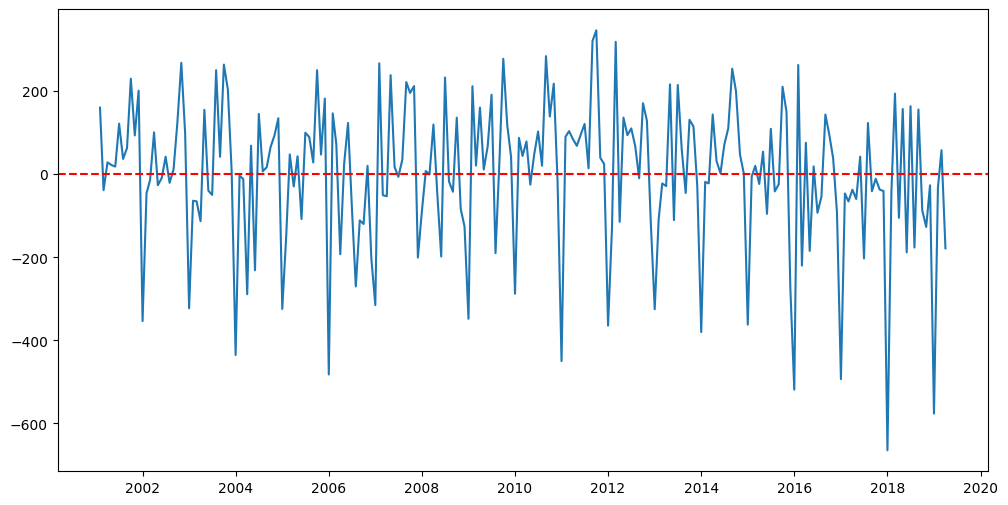

In [97]:
fig = plt.figure(figsize=(12, 6))
plt.plot(residuals,label="Residuales")
plt.axhline(y=0, color='r', linestyle='--')

In [98]:
from statsmodels.stats.diagnostic import het_arch

# Prueba de ARCH para heterocedasticidad
arch_test = het_arch(residuals)
print(f'ARCH Test Statistic: {arch_test[0]}')
print(f'p-value: {arch_test[1]}')

ARCH Test Statistic: 15.244636693401722
p-value: 0.12339412805009743


#### 
- El p-valor es mayor que 0.05, lo que significa que no se puede rechazar la hipótesis nula. La hipótesis nula de la prueba ARCH es que no hay heterocedasticidad en los residuos,es decir, los residuos tienen varianza constante.

## **10. Hacer Boostrap para el tema de Normalidad**

c:\Users\aleja\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


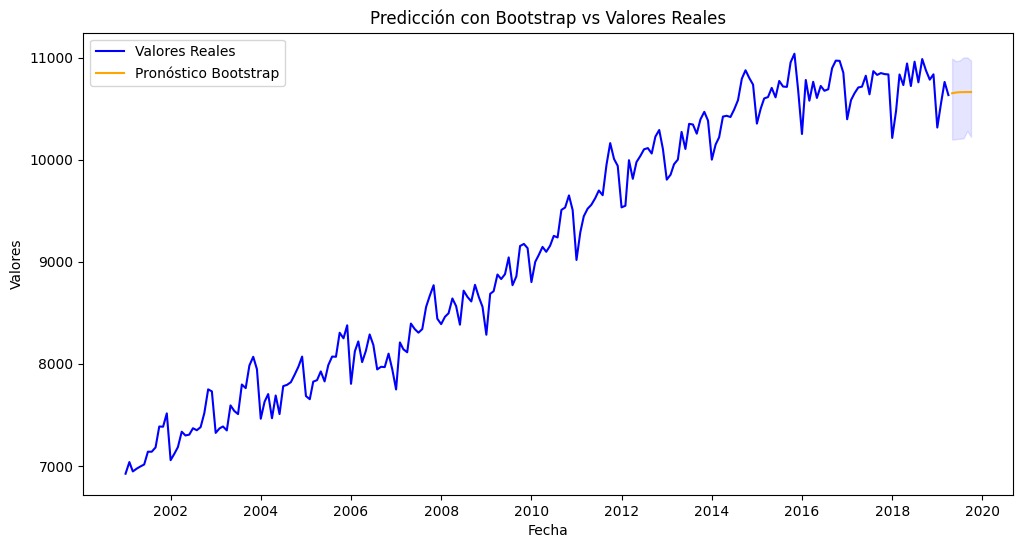

In [121]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data["Ocupados"], order=(1,1,1)).fit()

# Parámetros de bootstrap
h = 6  # Horizonte de predicción de 10 períodos
n_bootstrap = 1000  # Número de muestras bootstrap

# Realizar el pronóstico puntual y obtener los residuos
forecast = model.get_forecast(steps=h)
residuals = model.resid

# Inicializar un array para almacenar las muestras bootstrap
bootstrap_forecasts = np.zeros((n_bootstrap, h))

# Realizar la simulación bootstrap
for i in range(n_bootstrap):
    # Muestrear con reemplazo de los residuos
    sampled_residuals = np.random.choice(residuals, size=h, replace=True)
    
    # Generar la predicción de bootstrap sumando los residuos simulados
    bootstrap_forecasts[i, :] = forecast.predicted_mean + sampled_residuals

# Calcular los intervalos de confianza de bootstrap
point_forecast = forecast.predicted_mean
lower_bound = np.percentile(bootstrap_forecasts, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_forecasts, 97.5, axis=0)

# Generar el índice temporal para las predicciones (suponiendo datos mensuales)
x_for = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=h, freq='MS')

# Graficar los valores reales y las predicciones bootstrap
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar los datos reales
ax.plot(data.index, data["Ocupados"], label="Valores Reales", color='blue')

# Graficar las predicciones puntuales
ax.plot(x_for, point_forecast, label="Pronóstico Bootstrap", color='orange')

# Agregar la banda de confianza calculada con bootstrap
ax.fill_between(x_for, lower_bound, upper_bound, color='blue', alpha=0.1)

# Ajustar etiquetas y leyenda
ax.set_title("Predicción con Bootstrap vs Valores Reales")
ax.set_xlabel("Fecha")
ax.set_ylabel("Valores")
ax.legend()

# Mostrar la gráfica
plt.show()

In [126]:
# Crear el DataFrame de resultados
resumen_resultados = pd.DataFrame({
    'Mes': x_for,
    'Valor Pronosticado': point_forecast,
    'Confianza Inferior': lower_bound,
    'Confianza Superior': upper_bound
})

resumen_resultados

,Mes,Valor Pronosticado,Confianza Inferior,Confianza Superior
2019-05-01,2019-05-01,10650.087385,10196.671357,10989.215868
2019-06-01,2019-06-01,10657.294193,10200.818449,10964.551236
2019-07-01,2019-07-01,10660.170154,10204.306637,10970.848346
2019-08-01,2019-08-01,10661.317840,10207.964568,11000.217597
2019-09-01,2019-09-01,10661.775838,10281.661066,11000.904321
2019-10-01,2019-10-01,10661.958607,10222.261671,10969.215650
